In [177]:
import os
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont
import cv2 

from matplotlib import pyplot as plt

In [178]:
import fontconfig

# find a font file
fonts = fontconfig.query(lang='en')
for i in range(1, len(fonts)):
    if fonts[i].fontformat == 'TrueType':
        absolute_path = fonts[i].file
        
        print(absolute_path)
        break

/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf


In [179]:
image_file = json.load(open('../datasets/vg/image_data.json'))
vocab_file = json.load(open('../datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File('../datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [180]:
# load detected results
path = '../checkpoints/iba0.02_s2_inv_prop0.03_power0.5_sum_v3-predcls/'
detected_origin_path = path + 'inference/VG_stanford_filtered_with_attribute_test/'
dir_fmap = path + '/rib/'

In [181]:
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [182]:
def get_union(box1, box2): 
    ubox = [0, 0, 0, 0]
    
    ubox[0] = min(box1[0], box2[0])
    ubox[1] = min(box1[1], box2[1])
    ubox[2] = max(box1[2], box2[2])
    ubox[3] = max(box1[3], box2[3])
    return ubox

In [183]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = groundtruth.bbox
    
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [184]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    
    # get a font
    fnt = ImageFont.truetype(absolute_path, 14, encoding="unic")
    
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+60, y1+15)), fill=color)
        info = draw_info
        draw.text((x1, y1), info, font=fnt)
        
def draw_union_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    
    # get a font
    fnt = ImageFont.truetype(absolute_path, 14, encoding="unic")
    
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    
    draw.rectangle(((x1-1, y1-1), (x2+1, y2+1)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y2-15), (x1+190, y2)), fill=color)
        info = draw_info
        draw.text((x1 + 5, y2-15), info, font=fnt)

def print_list(name, input_list):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20])
    print('*' * 50)
    
    return None

In [185]:
gt_path = './gt_boxes/'
try:
    os.mkdir(gt_path)
except :
    None

In [186]:
idx = 1

In [187]:
img_path,boxes,labels,gt_rels,pred_rels,pred_rel_score,pred_rel_label= get_info_by_idx(
        idx=idx,det_input=detected_origin_result)
    
img_name = img_path.split('/')[-1].split('.')[0]  

np_boxes = boxes.cpu().numpy().astype(int)

img = cv2.imread(img_path)

# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

[ 97 161 193 358]
[ 32  88 495 287]
[32, 88, 495, 358]


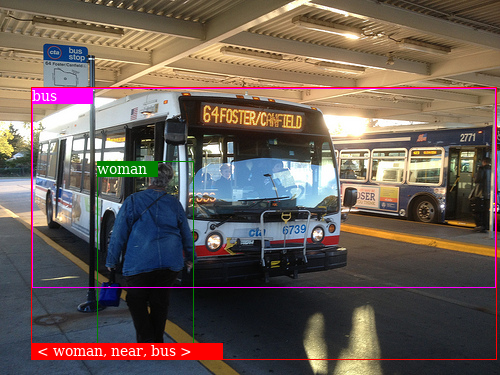

./gt_boxes/2343728_1.pdf


In [188]:
rel_idx = 1
        
img_rel_name = gt_path + img_name + '_{}.pdf'.format(str(rel_idx))

im_pil = Image.fromarray(img)

subj_idx = int(gt_rels[rel_idx][0].split('-')[0])
obj_idx = int(gt_rels[rel_idx][2].split('-')[0])

subj_label = gt_rels[rel_idx][0].split('-')[1]
obj_label = gt_rels[rel_idx][2].split('-')[1]
rel_label = gt_rels[rel_idx][1]

union_box = get_union(np_boxes[subj_idx], np_boxes[obj_idx])

print(np_boxes[subj_idx])

print(np_boxes[obj_idx])

print(union_box)

draw_single_box(im_pil, np_boxes[subj_idx], draw_info=subj_label, color='green')
draw_single_box(im_pil, np_boxes[obj_idx], draw_info=obj_label, color='magenta')

gt_triplet = '< ' + subj_label + ', ' + rel_label + ', ' + obj_label + ' >' 
draw_union_box(im_pil, union_box, draw_info=gt_triplet, color='red')

display(im_pil)
print(img_rel_name)

In [ ]:
for idx in range(10, 200):
    
    img_path,boxes,labels,gt_rels,pred_rels,pred_rel_score,pred_rel_label= get_info_by_idx(
        idx=idx,det_input=detected_origin_result)
    
    img_name = img_path.split('/')[-1].split('.')[0]  
    
    np_boxes = boxes.cpu().numpy().astype(int)
    
    img = cv2.imread(img_path)

    # You may need to convert the color.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for rel_idx in range(len(gt_rels)):
        
        img_rel_name = gt_path + img_name + '_{}.pdf'.format(str(rel_idx))

        im_pil = Image.fromarray(img)

        subj_idx = int(gt_rels[rel_idx][0].split('-')[0])
        obj_idx = int(gt_rels[rel_idx][2].split('-')[0])

        subj_label = gt_rels[rel_idx][0].split('-')[1]
        obj_label = gt_rels[rel_idx][2].split('-')[1]
        rel_label = gt_rels[rel_idx][1]

        union_box = get_union(np_boxes[subj_idx], np_boxes[obj_idx])

        draw_single_box(im_pil, np_boxes[subj_idx], draw_info=subj_label, color='green')
        draw_single_box(im_pil, np_boxes[obj_idx], draw_info=obj_label, color='magenta')

        gt_triplet = '< ' + subj_label + ', ' + rel_label + ', ' + obj_label + ' >' 
        draw_union_box(im_pil, union_box, draw_info=gt_triplet, color='red')


        print(img_rel_name)
        #display(im_pil)
        
        plt.imshow(im_pil)
        plt.axis('off')
        plt.savefig(img_rel_name, dpi=200)

./gt_boxes/2343718_0.pdf
./gt_boxes/2343718_1.pdf
./gt_boxes/2343718_2.pdf
./gt_boxes/2343718_3.pdf
./gt_boxes/2343718_4.pdf
./gt_boxes/2343718_5.pdf
./gt_boxes/2343718_6.pdf
./gt_boxes/2343718_7.pdf
./gt_boxes/2343718_8.pdf
./gt_boxes/2343718_9.pdf
./gt_boxes/2343718_10.pdf
./gt_boxes/2343718_11.pdf
./gt_boxes/2343718_12.pdf
./gt_boxes/2343718_13.pdf
./gt_boxes/2343716_0.pdf
./gt_boxes/2343716_1.pdf
./gt_boxes/2343716_2.pdf
./gt_boxes/2343716_3.pdf
./gt_boxes/2343716_4.pdf
./gt_boxes/2343716_5.pdf
./gt_boxes/2343716_6.pdf
./gt_boxes/2343716_7.pdf
./gt_boxes/2343716_8.pdf
./gt_boxes/2343716_9.pdf
./gt_boxes/2343716_10.pdf
./gt_boxes/2343716_11.pdf
./gt_boxes/2343716_12.pdf
./gt_boxes/2343716_13.pdf
./gt_boxes/2343716_14.pdf
./gt_boxes/2343716_15.pdf
./gt_boxes/2343716_16.pdf
./gt_boxes/2343715_0.pdf
./gt_boxes/2343715_1.pdf
./gt_boxes/2343715_2.pdf
./gt_boxes/2343715_3.pdf
./gt_boxes/2343715_4.pdf
./gt_boxes/2343715_5.pdf
./gt_boxes/2343715_6.pdf
./gt_boxes/2343715_7.pdf
./gt_boxes/234

./gt_boxes/2343675_8.pdf
./gt_boxes/2343675_9.pdf
./gt_boxes/2343675_10.pdf
./gt_boxes/2343674_0.pdf
./gt_boxes/2343674_1.pdf
./gt_boxes/2343674_2.pdf
./gt_boxes/2343674_3.pdf
./gt_boxes/2343674_4.pdf
./gt_boxes/2343674_5.pdf
./gt_boxes/2343674_6.pdf
./gt_boxes/2343674_7.pdf
./gt_boxes/2343674_8.pdf
./gt_boxes/2343673_0.pdf
./gt_boxes/2343673_1.pdf
./gt_boxes/2343673_2.pdf
./gt_boxes/2343673_3.pdf
./gt_boxes/2343673_4.pdf
./gt_boxes/2343673_5.pdf
./gt_boxes/2343673_6.pdf
./gt_boxes/2343671_0.pdf
./gt_boxes/2343671_1.pdf
./gt_boxes/2343671_2.pdf
./gt_boxes/2343671_3.pdf
./gt_boxes/2343671_4.pdf
./gt_boxes/2343671_5.pdf
./gt_boxes/2343671_6.pdf
./gt_boxes/2343671_7.pdf
./gt_boxes/2343671_8.pdf
./gt_boxes/2343671_9.pdf
./gt_boxes/2343671_10.pdf
./gt_boxes/2343671_11.pdf
./gt_boxes/2343671_12.pdf
./gt_boxes/2343671_13.pdf
./gt_boxes/2343671_14.pdf
./gt_boxes/2343671_15.pdf
./gt_boxes/2343671_16.pdf
./gt_boxes/2343670_0.pdf
./gt_boxes/2343670_1.pdf
./gt_boxes/2343670_2.pdf
./gt_boxes/234367

./gt_boxes/2343632_8.pdf
./gt_boxes/2343632_9.pdf
./gt_boxes/2343632_10.pdf
./gt_boxes/2343632_11.pdf
./gt_boxes/2343631_0.pdf
./gt_boxes/2343631_1.pdf
./gt_boxes/2343631_2.pdf
./gt_boxes/2343631_3.pdf
./gt_boxes/2343631_4.pdf
./gt_boxes/2343631_5.pdf
./gt_boxes/2343630_0.pdf
./gt_boxes/2343630_1.pdf
./gt_boxes/2343630_2.pdf
./gt_boxes/2343630_3.pdf
./gt_boxes/2343630_4.pdf
./gt_boxes/2343630_5.pdf
./gt_boxes/2343630_6.pdf
./gt_boxes/2343630_7.pdf
./gt_boxes/2343630_8.pdf
./gt_boxes/2343630_9.pdf
./gt_boxes/2343630_10.pdf
./gt_boxes/2343630_11.pdf
./gt_boxes/2343630_12.pdf
./gt_boxes/2343630_13.pdf
./gt_boxes/2343630_14.pdf
./gt_boxes/2343630_15.pdf
./gt_boxes/2343629_0.pdf
./gt_boxes/2343629_1.pdf
./gt_boxes/2343629_2.pdf
./gt_boxes/2343629_3.pdf
./gt_boxes/2343629_4.pdf
./gt_boxes/2343629_5.pdf
./gt_boxes/2343629_6.pdf
./gt_boxes/2343628_0.pdf
./gt_boxes/2343628_1.pdf
./gt_boxes/2343628_2.pdf
./gt_boxes/2343628_3.pdf
./gt_boxes/2343628_4.pdf
./gt_boxes/2343628_5.pdf
./gt_boxes/234362

./gt_boxes/2343584_4.pdf
./gt_boxes/2343584_5.pdf
./gt_boxes/2343583_0.pdf
./gt_boxes/2343583_1.pdf
./gt_boxes/2343583_2.pdf
./gt_boxes/2343583_3.pdf
./gt_boxes/2343583_4.pdf
./gt_boxes/2343583_5.pdf
./gt_boxes/2343583_6.pdf
./gt_boxes/2343583_7.pdf
./gt_boxes/2343583_8.pdf
./gt_boxes/2343583_9.pdf
./gt_boxes/2343583_10.pdf
./gt_boxes/2343583_11.pdf
./gt_boxes/2343583_12.pdf
./gt_boxes/2343583_13.pdf
./gt_boxes/2343581_0.pdf
./gt_boxes/2343581_1.pdf
./gt_boxes/2343581_2.pdf
./gt_boxes/2343581_3.pdf
./gt_boxes/2343581_4.pdf
./gt_boxes/2343581_5.pdf
./gt_boxes/2343581_6.pdf
./gt_boxes/2343581_7.pdf
./gt_boxes/2343581_8.pdf
./gt_boxes/2343581_9.pdf
./gt_boxes/2343581_10.pdf
./gt_boxes/2343581_11.pdf
./gt_boxes/2343580_0.pdf
./gt_boxes/2343580_1.pdf
./gt_boxes/2343580_2.pdf
./gt_boxes/2343580_3.pdf
./gt_boxes/2343580_4.pdf
./gt_boxes/2343580_5.pdf
./gt_boxes/2343579_0.pdf
./gt_boxes/2343579_1.pdf
./gt_boxes/2343579_2.pdf
./gt_boxes/2343579_3.pdf
./gt_boxes/2343579_4.pdf
./gt_boxes/2343579_

./gt_boxes/2343539_2.pdf
./gt_boxes/2343539_3.pdf
./gt_boxes/2343539_4.pdf
./gt_boxes/2343539_5.pdf
./gt_boxes/2343539_6.pdf
./gt_boxes/2343538_0.pdf
./gt_boxes/2343538_1.pdf
./gt_boxes/2343538_2.pdf
./gt_boxes/2343538_3.pdf
./gt_boxes/2343538_4.pdf
./gt_boxes/2343538_5.pdf
./gt_boxes/2343538_6.pdf
./gt_boxes/2343538_7.pdf
./gt_boxes/2343538_8.pdf
./gt_boxes/2343538_9.pdf
./gt_boxes/2343538_10.pdf
./gt_boxes/2343538_11.pdf
./gt_boxes/2343538_12.pdf
./gt_boxes/2343538_13.pdf
./gt_boxes/2343538_14.pdf
./gt_boxes/2343538_15.pdf
./gt_boxes/2343538_16.pdf
./gt_boxes/2343538_17.pdf
./gt_boxes/2343538_18.pdf
./gt_boxes/2343538_19.pdf
./gt_boxes/2343538_20.pdf
./gt_boxes/2343538_21.pdf
./gt_boxes/2343538_22.pdf
./gt_boxes/2343538_23.pdf
./gt_boxes/2343538_24.pdf
./gt_boxes/2343538_25.pdf
./gt_boxes/2343538_26.pdf
./gt_boxes/2343538_27.pdf
./gt_boxes/2343538_28.pdf
./gt_boxes/2343538_29.pdf
./gt_boxes/2343538_30.pdf
./gt_boxes/2343538_31.pdf
./gt_boxes/2343538_32.pdf
./gt_boxes/2343538_33.pdf
.

./gt_boxes/2343512_0.pdf
./gt_boxes/2343512_1.pdf
./gt_boxes/2343512_2.pdf
./gt_boxes/2343511_0.pdf
./gt_boxes/2343510_0.pdf
./gt_boxes/2343510_1.pdf
./gt_boxes/2343510_2.pdf
./gt_boxes/2343510_3.pdf
./gt_boxes/2343510_4.pdf
./gt_boxes/2343510_5.pdf
./gt_boxes/2343510_6.pdf
./gt_boxes/2343510_7.pdf
./gt_boxes/2343510_8.pdf
./gt_boxes/2343509_0.pdf
./gt_boxes/2343509_1.pdf
./gt_boxes/2343509_2.pdf
./gt_boxes/2343509_3.pdf
./gt_boxes/2343509_4.pdf
./gt_boxes/2343509_5.pdf
./gt_boxes/2343508_0.pdf
./gt_boxes/2343508_1.pdf
./gt_boxes/2343506_0.pdf
./gt_boxes/2343506_1.pdf
./gt_boxes/2343506_2.pdf
./gt_boxes/2343506_3.pdf
./gt_boxes/2343506_4.pdf
./gt_boxes/2343506_5.pdf
./gt_boxes/2343505_0.pdf
./gt_boxes/2343505_1.pdf
./gt_boxes/2343505_2.pdf
./gt_boxes/2343505_3.pdf
./gt_boxes/2343504_0.pdf
./gt_boxes/2343504_1.pdf
./gt_boxes/2343504_2.pdf
./gt_boxes/2343504_3.pdf
./gt_boxes/2343504_4.pdf
./gt_boxes/2343504_5.pdf
./gt_boxes/2343504_6.pdf
./gt_boxes/2343504_7.pdf
./gt_boxes/2343504_8.pdf
